### importing the libraries

In [ ]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
import numpy as np # linear algebra
import pandas as pd
import os
print(os.listdir("/content/drive/MyDrive/Strokefaces"))


['Traning Set', 'Test Set', 'Validation Set']


In [ ]:
import time
import pandas as pd
import os,shutil,math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import ImageDraw
from glob import glob


from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,BatchNormalization,Activation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

from keras.callbacks import EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [ ]:
train_data_dir = '/content/drive/MyDrive/Strokefaces/Traning Set'
img_width, img_height = 299, 299 
batch_size = 32
validation_dir = '/content/drive/MyDrive/Strokefaces/Validation Set'


### Image Augmentation

In [ ]:
image_datagen = ImageDataGenerator(
    rescale=1./255, 
    vertical_flip = True,
    horizontal_flip = True,
    rotation_range=20,
    shear_range=0.05,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
    #channel_shift_range=0.1
)
train_gen = image_datagen.flow_from_directory(
        train_data_dir, 
        target_size=(img_height, img_width), 
        batch_size=batch_size, 
        class_mode="categorical", 
        subset="training")
valid_gen = image_datagen.flow_from_directory(
        validation_dir, 
        target_size=(img_height, img_width), 
        batch_size=batch_size, 
        class_mode="categorical", 
        subset="validation")

Found 1707 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


### Hyperparameters

In [ ]:
# Hyperparameters
second_dense_512 = [0, 1]
dropout = [0, 1]

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
print('Loaded model!')

87924736/87910968 [==============================] - 1s 0us/step
Loaded model!


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
for layer in base_model.layers:
    layer.trainable = False 
        
for dense2 in second_dense_512:
    for drop in dropout:
        
        NAME = "strokefaces-inception-dense{}-drop{}-{}".format(dense2, drop, int(time.time()))
        print(NAME)
        logdir = "logs/strokefaces-inception/{}/".format(NAME)
        
        # Callbacks
        checkpoint = ModelCheckpoint(
            '{}base.model'.format(logdir),
            monitor='val_loss',
            mode='min',
            save_weights_only=True,
            save_best_only = True,
            verbose = 1)
        tensorboard = TensorBoard(
            log_dir = logdir,
            histogram_freq=0,
            batch_size=batch_size,
            write_graph=True,
            write_grads=True,
            write_images=False,
        )

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        if drop == 1 : x = Dropout(0.3)(x)
        if dense2 == 1 : 
            x = Dense(512)(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            if drop == 1 : x = Dropout(0.3)(x)
        
        predictions = Dense(2, activation='softmax')(x)
        
        model = Model(base_model.input, predictions)
        
        
        model.compile(loss='categorical_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])

strokefaces-inception-dense0-drop0-1630513845
strokefaces-inception-dense0-drop1-1630513845
strokefaces-inception-dense1-drop0-1630513845
strokefaces-inception-dense1-drop1-1630513846


In [ ]:
history = model.fit(
            train_gen,
            steps_per_epoch = train_gen.n // train_gen.batch_size, #normalde len(X_train) / batch_size,
            epochs= 10,
            validation_data = valid_gen,
            validation_steps=valid_gen.n // valid_gen.batch_size, # normalde len(X_valid) / batch_size,
            verbose=1,
            callbacks=[tensorboard])
       

Epoch 1/10
53/53 [==============================] - 541s 10s/step - loss: 0.2244 - accuracy: 0.9176 - val_loss: 0.1064 - val_accuracy: 0.9792
Epoch 2/10
53/53 [==============================] - 47s 875ms/step - loss: 0.1449 - accuracy: 0.9493 - val_loss: 0.0938 - val_accuracy: 0.9583
Epoch 3/10
53/53 [==============================] - 47s 876ms/step - loss: 0.1096 - accuracy: 0.9588 - val_loss: 0.0716 - val_accuracy: 0.9792
Epoch 4/10
53/53 [==============================] - 45s 853ms/step - loss: 0.0900 - accuracy: 0.9719 - val_loss: 0.2033 - val_accuracy: 0.9583
Epoch 5/10
53/53 [==============================] - 47s 885ms/step - loss: 0.1049 - accuracy: 0.9630 - val_loss: 0.1008 - val_accuracy: 0.9479
Epoch 6/10
53/53 [==============================] - 47s 888ms/step - loss: 0.0730 - accuracy: 0.9731 - val_loss: 0.1707 - val_accuracy: 0.9479
Epoch 7/10
53/53 [==============================] - 47s 885ms/step - loss: 0.0477 - accuracy: 0.9821 - val_loss: 0.0493 - val_accuracy: 0.9792


### **Result**

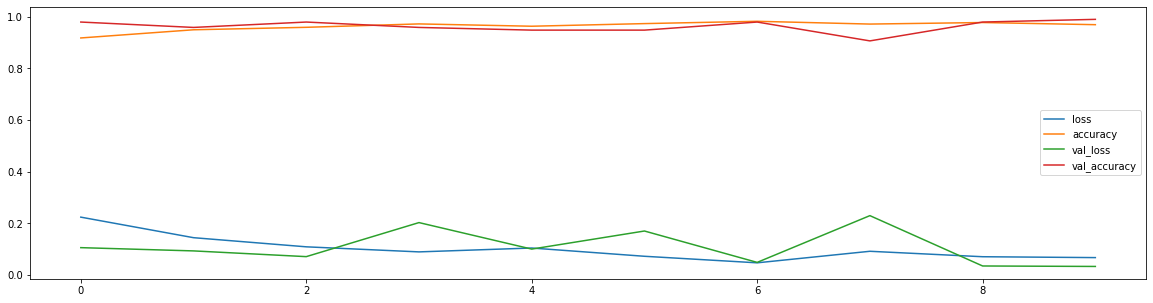

In [ ]:
pd.DataFrame(history.history).plot(figsize=(20,5))
plt.show()